System information (for reproducibility):

In [312]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 1 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 
  DYLD_FALLBACK_LIBRARY_PATH = /Users/tomokiokuno/.julia/artifacts/5902919ba30b97bafa388ca950a351ea32516d26/lib:/Users/tomokiokuno/.julia/artifacts/92b949e2f3a66439c69a8d334fc95810fbd9df9b/lib:/Users/tomokiokuno/.julia/artifacts/5b338c8fa90c05e6faea86e54d2996cca76cfbbe/lib:/Applications/Julia-1.10.app/Contents/Resources/julia/lib/julia:/Users/tomokiokuno/.julia/artifacts/0b234a64c0574e6156c740b15844963c0555164e/lib:/Users/tomokiokuno/.julia/artifacts/9410bad2635eda2239b4a72ba4316c4aa8f5b76e/lib:/Users/tomokiokuno/.julia/artifacts/a7cf2895cac9b6bec2c94e6490ca337e00b12894/lib:/Users/tomokiokuno/.julia/artifacts/10b2b258c07d7a76b2e3331f1ed70d8a8eb6d71c/lib:/

Load packages:

In [313]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/07_UCLA/Class/257/02_Homework/hw2`


Status `~/Documents/07_UCLA/Class/257/02_Homework/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [8bb1440f] DelimitedFiles v1.9.1
  [7073ff75] IJulia v1.24.2
  [86fae568] ImageView v0.12.1
  [916415d5] Images v0.26.1
  [bdcacae8] LoopVectorization v0.12.169
  [91a5bcdd] Plots v1.40.4
  [08abe8d2] PrettyTables v2.3.1
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [314]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random
using Plots

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

**Solution**

Most importantly, we can rewrite the objective function as follow.
\begin{align*}
L(\mathbf{V}, \mathbf{W})
&= \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 \\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{tr}(\mathbf X'\mathbf V\mathbf W) + \text{tr}(\mathbf V'\mathbf V\mathbf W\mathbf W')\\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{dot}(\mathbf W, \mathbf V'\mathbf X) + \text{tr}(\mathbf V'\mathbf V\mathbf W\mathbf W').
\end{align*}
Note that we should avoid calculating $\mathbf{VW}$ and $\mathbf X'\mathbf V\mathbf W$, which is large.

I first define my own *squared* Frobenious norm (`mynorm`) and dot product (`mydot`), which are slightly faster than the original `norm()^2` and `dot()`

In [315]:
function mynorm(A) 
    x = zero(eltype(A))
    @inbounds @simd for v in A
      @fastmath x += v * v
    end
    x # not sqrt(x) for efficiency
end

function mydot(A, B) 
    x = zero(eltype(A))
    @inbounds @simd for i in eachindex(A)
      @fastmath x += A[i] * B[i]
    end
    x
end

mydot (generic function with 1 method)

I noticed that calculating $\mathbf V \mathbf W$ is not wise since it has the same size as $\mathbf X$, which is inefficient.

In [316]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    
    # preallocate necessary matrices
    # WWt    = similar(X, r, r)
    # VtV    = similar(X, r, r)
    VtVWWt = similar(X, r, r) # use it as WWt and VtV as well
    XWt    = similar(X, size(X, 1), r) # for update V
    VWWt   = similar(X, size(X, 1), r) # for update V 
    VtX    = similar(X, r, size(X, 2)) # for update W 
    VtVW   = similar(X, r, size(X, 2)) # for update W
    # WtVtX  = similar(X, size(X, 2), size(X, 2)) # unnecessary with dot() instead of tr()
    
    # obj at start point
    normXsq = mynorm(X) # squared internaly in my own function
    mul!(VtVWWt, V', V) # still VtV
    mul!(VtVW, VtVWWt, W) # VtVW 
    mul!(VtVWWt, VtVW, W') # get VtVWWt here!
    mul!(VtX, V', X)
    # mul!(WtVtX, W', VtX)

    # obj = norm(X - VW)^2 # very memory intensive
    # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
    # obj = normXsq - 2mydot(W, VtX) + mydot(WWt, VtV) 
    obj = normXsq - 2mydot(W, VtX) + tr(VtVWWt)
    niter = 0
    
    # Loop
    for iter in 1:maxiter
        # update V
        mul!(XWt, X, W')
        mul!(VtVWWt, W, W') # still WWt
        mul!(VWWt, V, VtVWWt) # VWWt
        # V .= V .* ((X * W') ./ (V * W * W')) # very memory intensive
        @. V *= XWt / VWWt
        
        # update W
        mul!(VtX, V', X)
        mul!(VtVWWt, V', V) # still VtV
        mul!(VtVW, VtVWWt, W) # VtVW
        # W .= W .* ((V' * X) ./ (V' * V * W)) # very memory intensive
        @. W *= VtX / VtVW

        # update obj
        obj_old = obj
        mul!(VtVWWt, W, W') # still WWt
        mul!(VWWt, V, VtVWWt) # VWWt 
        mul!(VtVWWt, V', VWWt) # get VtVWWt here!
        mul!(VtX, V', X)
    
        # mul!(WtVtX, W', VtX)
        # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
        # obj = normXsq - 2mydot(W, VtX) + mydot(WWt, VtV)
        obj = normXsq - 2mydot(W, VtX) + tr(VtVWWt)
        # convergence check
        if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 2 methods)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

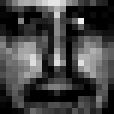

In [317]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

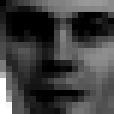

In [318]:
colorview(Gray, reshape(X[10, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

**Solution**

In [319]:
# test
r = 10
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64)
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
_, _, obj, niter = nnmf(X, r, V = V0, W = W0)
@btime nnmf($X, $r, V = $V0, W = $W0) setup=(
    copyto!(V0, V0full[:, 1:r]), 
    copyto!(W0, W0full[1:r, :])
    )
println("obj=$obj, niter=$niter")

  767.488 ms (9 allocations: 437.19 KiB)
obj=11730.388009855335, niter=239


In [320]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  802.443 ms (9 allocations: 437.19 KiB)
obj=11730.388009855335, niter=239
r=20
  1.030 s (9 allocations: 875.44 KiB)
obj=8497.222317850887, niter=394
r=30
  1.295 s (9 allocations: 1.28 MiB)
obj=6621.627345486922, niter=482
r=40
  1.235 s (9 allocations: 1.72 MiB)
obj=5256.663870564196, niter=581
r=50
  1.726 s (10 allocations: 2.15 MiB)
obj=4430.201581697722, niter=698


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

Choose $r = 30$. First, we use the original $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ to obtain the objective value and $(\mathbf{V}, \mathbf{W})$.

In [321]:
r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V1, W1, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
#     copyto!(V0, V0full[:, 1:r]), 
#     copyto!(W0, W0full[1:r, :])
#     )
println("obj=$obj, niter=$niter")
# display(V1)
# display(W1)

r=50
obj=4430.201581697722, niter=698


I create new $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ that have the same mean and standard deviation as the original and then algorithm with $r = 50$. If the elements are negative, take absolute values.

In [322]:
# obtain mean and std of V0full and W0full
Random.seed!(123)
meanV = mean(V0full)
stdV = std(V0full)
meanW = mean(W0full)
stdW = std(W0full)

# produce new V0full and W0full with positive elements
V0full2 = abs.(randn(size(V0full)) .* stdV .+ meanV)
W0full2 = abs.(randn(size(W0full)) .* stdW .+ meanW)

r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
V0 = V0full2[:, 1:r]
W0 = W0full2[1:r, :]
V2, W2, obj, niter = nnmf(X, r, V = V0, W = W0)
@btime nnmf($X, $r, V = $V0, W = $W0) setup=(
    copyto!(V0, V0full[:, 1:r]), 
    copyto!(W0, W0full[1:r, :])
    )
println("obj=$obj, niter=$niter")
# display(V2)
# display(W2)

r=50
  6.625 s (10 allocations: 2.15 MiB)
obj=4493.259496835322, niter=807


Different objective value(s) and iteration number(s) with the same allocation(s) and almost the same memory usage. Check the difference in $(\mathbf{V}, \mathbf{W})$.

In [323]:
isapprox(V1, V2, atol=1e-2) && isapprox(W1, W2, atol=1e-2),
isapprox(V1, V2, atol=1e-1) && isapprox(W1, W2, atol=1e-1)

(true, true)

As expected from the difference in `obj`, the two sets of $(\mathbf{V}, \mathbf{W})$ were also different.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

In [324]:
r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
V0 = ones(size(X, 1), r)
W0 = ones(r, size(X, 2))
V3, W3, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
#     copyto!(V0, V0full[:, 1:r]), 
#     copyto!(W0, W0full[1:r, :])
#     )
println("obj=$obj, niter=$niter")
# display(V2)
# display(W2)

r=50
obj=25297.016511083144, niter=3


In [325]:
isapprox(V1, V3, atol=1e-1) && isapprox(W1, W3, atol=1e-1)

false

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

**Solution**

Recall that I stored the originak $\mathbf{W}$ for $r = 50$ as `W1`.

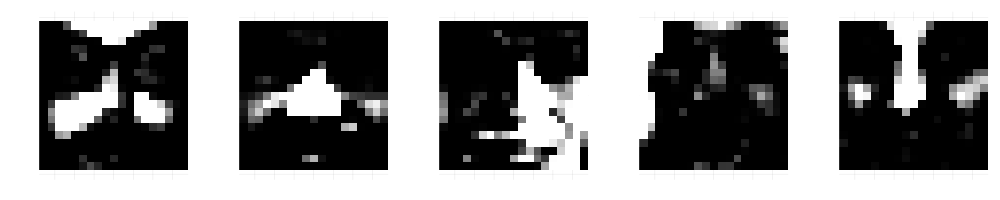

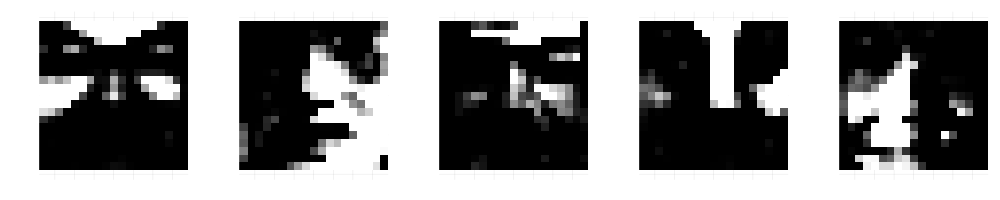

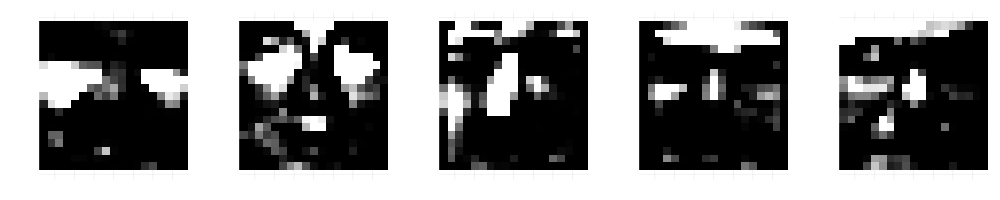

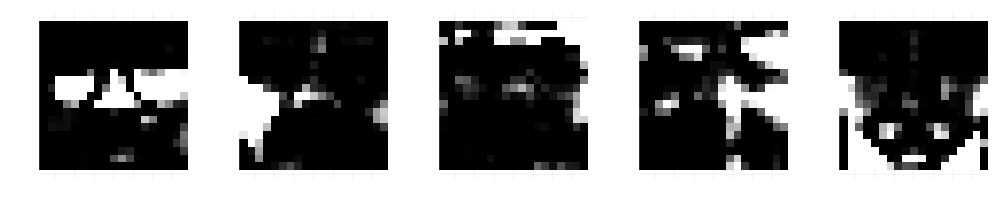

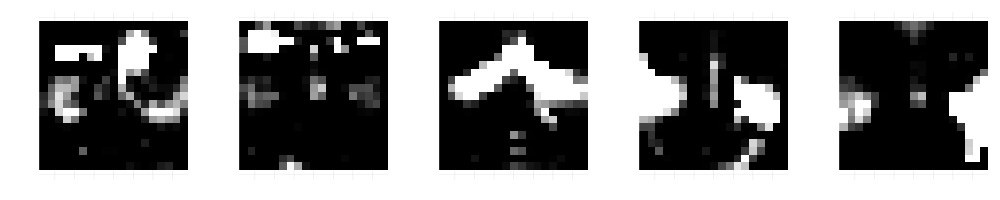

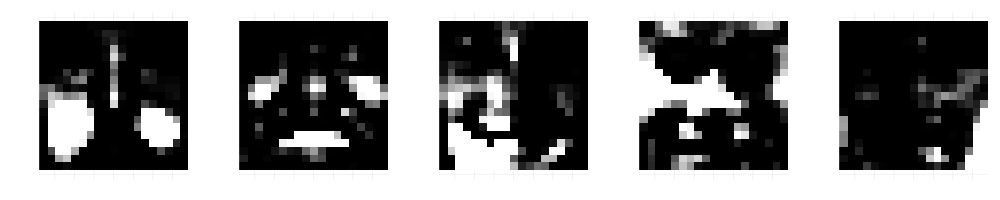

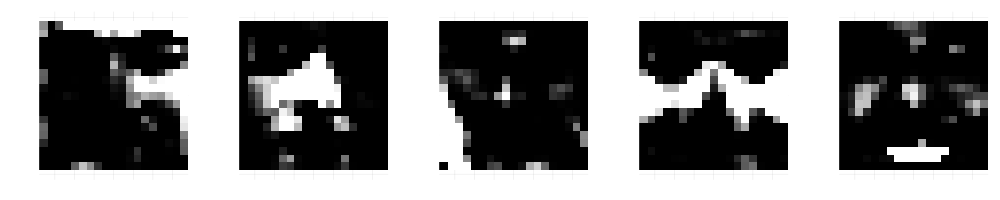

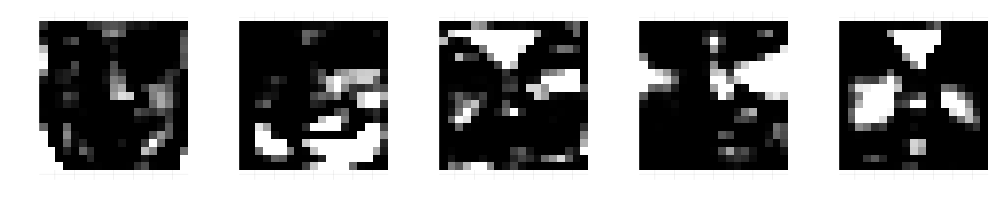

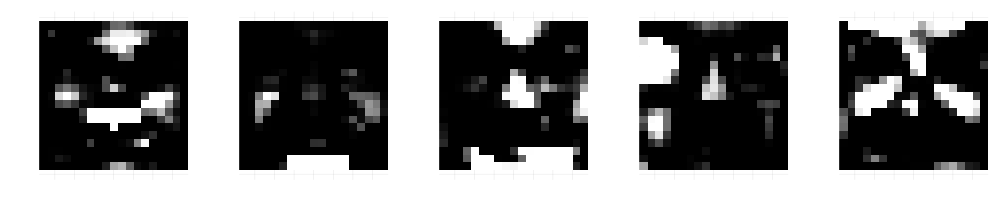

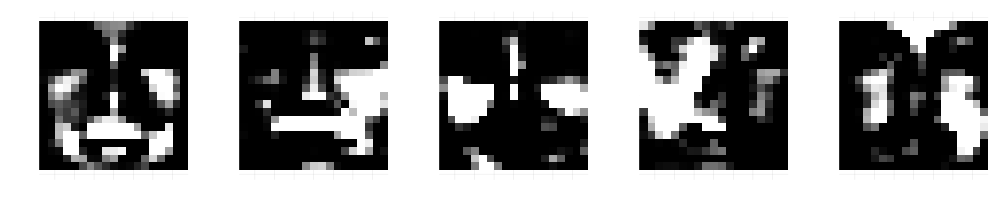

In [326]:
# put rows of W at rank r = 50 (obtained before)
images = [colorview(Gray, reshape(W[i, :], 19, 19)) for i in 1:50]

for i in 1:5:46
    p = plot(layout = (1, 5), size = (1000, 200)) 
    for j in i:(i + 4)
        heatmap!(p, images[j], c = :grays, axis = false, subplot = (j - i + 1))  
    end
    display(p)
end 

V is loading matrix and W is basis image matrix.
W is a part of the fase

### Q1.7 GPU (optional)

Investigate the GPU capabilities of your computer. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

**Solution**